In [7]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

# Arbeitsverzeichnis setzen
working_dir = Path("~/data/religion")
os.chdir(working_dir)

# Jahresliste und Daten einlesen
years = list(range(1850, 2000, 10))
if 2014 not in years:
    years.append(2014)

# Daten einlesen und nach gültigen Regionsnamen filtern
data = {}
for year in years:
    file_name = f"{year}.xlsx"
    df = pd.read_excel(file_name, skiprows=3)
    df = df[df['Regionsname'].notna()]
    data[year] = df

# Sukzessives Zusammenführen
full_dat = data[1850].copy()
full_dat = full_dat.rename(columns={full_dat.columns[2]: f"y_{1850}"})

for year in years[1:]:
    df = data[year].copy()
    df = df.rename(columns={df.columns[2]: f"y_{year}"})
    full_dat = pd.merge(full_dat, df[['Regions-ID', 'Regionsname', f'y_{year}']],
                        on=['Regions-ID', 'Regionsname'], how='right')

# Regions-ID in numerisch umwandeln
full_dat['Regions-ID'] = pd.to_numeric(full_dat['Regions-ID'], errors='coerce')

# Glarus-Spezialfall behandeln
gl = full_dat[(full_dat['Regions-ID'] >= 1602) & (full_dat['Regions-ID'] <= 1629)]
gl_long = gl.melt(id_vars=['Regions-ID', 'Regionsname'],
                  value_vars=[f'y_{year}' for year in years],
                  var_name='jahr', value_name='wert')

gl_count = gl_long.groupby(['jahr', 'wert']).size().reset_index(name='n')
gl_count = gl_count.sort_values(['jahr', 'n'], ascending=[True, False])
gl_count = gl_count.groupby('jahr').first().reset_index()[['jahr', 'wert']]
gl_count = gl_count.set_index("jahr").T

# Gemeinde-Codes einlesen
num = pd.read_excel("Gemeindestand.xlsx")
num = num.rename(columns={"BFS Gde-nummer": "Regions_ID"})

# Regions-ID nochmal für Merge vorbereiten
full_dat['Regions_ID'] = pd.to_numeric(full_dat['Regions-ID'], errors='coerce')

# Merge mit Kantonsinformationen
full_dat = pd.merge(full_dat, num, on='Regions_ID', how='right')

# Konvertiere Jahreswerte zu Kategorien
cols = [f"y_{year}" for year in years]
full_dat[cols] = full_dat[cols].astype('category')

# Glarus-Werte einfügen
gl_values = gl_count.iloc[0].to_dict()
full_dat.loc[full_dat['Kanton'] == 'GL', gl_values.keys()] = list(gl_values.values())

# Long Format + Jahr extrahieren
full_dat_long = full_dat.melt(id_vars=[col for col in full_dat.columns if col not in cols],
                              value_vars=cols, var_name='year', value_name='rel')
full_dat_long['year'] = full_dat_long['year'].str.extract(r'y_(\d+)').astype(int)

# Exportieren
output_path = working_dir / "rel_gemeinde_new.csv"
full_dat_long.to_csv(output_path, index=False)



ModuleNotFoundError: No module named 'pandas'

In [58]:
#--Daten Import
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. CSV-Datei laden (korrekter Pfad & Komma als Trennzeichen) ===
file_path = '~/data/religion/rel_gemeinde_new.csv'
df = pd.read_csv(file_path, sep=",", encoding="utf-8")


In [61]:
#--Wrangling
# === 2. Leere/unnötige Spalten entfernen ===
df = df.loc[:, ~df.columns.str.match(r"^Unnamed")]

# === 3. In Long-Format bringen ===
#id_vars = ['Regions_ID', 'Regionsname', 'Kanton']
#value_vars = [col for col in df.columns if col.startswith("y_")]

#df_long = pd.melt(df,
                  #id_vars=id_vars,
                  #value_vars=value_vars,
                  #var_name="Jahr",
                  #value_name="Religion")

# === 4. Jahr bereinigen (z. B. y_1850 → 1850 als int) ===
#df_long["Jahr"] = df_long["Jahr"].str.extract(r"y_(\d+)").astype(int)

# === 5. Encoding-Fehler beheben (‚â• → ≥) ===
#df_long["Religion"] = df_long["Religion"].astype(str).str.replace("‚â•", "≥", regex=False)


# === 6. Nur gültige Kantone (z. B. ZH, BE, AG etc.) ===
#df_long["Kanton"] = df_long["Kanton"].astype(str).str.strip()
#df_long = df_long[df_long["Kanton"].str.match(r"^[A-Z]{2}$")]

df_long=df

# === 7. Aggregation: häufigste Religion pro Kanton & Jahr ===
df_kanton_agg = (
    df_long
    .groupby(["Kanton", "year"])["rel"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
)

# Pivotieren: Religion pro Kanton und Jahr
df_pivot = df_kanton_agg.pivot(index="Kanton", columns="year", values="rel")

print(df_pivot)

output_path = working_dir / "rel_gemeinde_new.csv"
df_pivot.to_csv(output_path, index=True)


year                             1850                           1860  \
Kanton                                                                 
AG      Mehrheit katholisch: ≥ 80,0 %  Mehrheit katholisch: ≥ 80,0 %   
AI      Mehrheit katholisch: ≥ 80,0 %  Mehrheit katholisch: ≥ 80,0 %   
AR      Mehrheit reformiert: ≥ 80,0 %  Mehrheit reformiert: ≥ 80,0 %   
BE      Mehrheit reformiert: ≥ 80,0 %  Mehrheit reformiert: ≥ 80,0 %   
BL      Mehrheit reformiert: ≥ 80,0 %  Mehrheit reformiert: ≥ 80,0 %   
BS      Mehrheit reformiert: ≥ 80,0 %  Mehrheit reformiert: ≥ 80,0 %   
FR      Mehrheit katholisch: ≥ 80,0 %  Mehrheit katholisch: ≥ 80,0 %   
GE      Mehrheit katholisch: ≥ 80,0 %  Mehrheit katholisch: ≥ 80,0 %   
GL      Mehrheit reformiert: ≥ 80,0 %  Mehrheit reformiert: ≥ 80,0 %   
GR      Mehrheit reformiert: ≥ 80,0 %  Mehrheit reformiert: ≥ 80,0 %   
JU                               None                           None   
LU      Mehrheit katholisch: ≥ 80,0 %  Mehrheit katholisch: ≥ 80

* ## Hier werden die Kantone nach Religionen gruppiert, ab 75% giltet der Katon als stark reformiert oder katholisch, zwischen 55% und 75% als eher reformiert bzw. katholisch.

In [54]:
#-- Gruppierung

def religion_group(text):
    if pd.isna(text):
        return "Divers"
    
    text = text.lower()
    is_kat = "katholisch" in text
    is_ref = "reformiert" in text

    # Prozent extrahieren (z. B. "70–80%" oder "≥ 65%")
    # Auch "70–80 %", "≥ 70 %" etc. erlaubt
    match = re.search(r"(\d{1,2},?\d*)\s*[-–]\s*(\d{1,2},?\d*)%?", text)
    if match:
        lower = float(match.group(1).replace(",", "."))
        upper = float(match.group(2).replace(",", "."))
        avg = (lower + upper) / 2
    else:
        match_single = re.search(r"≥\s*(\d{1,2},?\d*)%?", text)
        if match_single:
            avg = float(match_single.group(1).replace(",", "."))
        else:
            return "Divers"

    # Neue Gruppierungslogik
    if is_kat:
        if avg > 75:
            return "Stark Katholisch"
        elif 55 <= avg <= 75:
            return "Eher Katholisch"
        else:
            return "Divers"
    elif is_ref:
        if avg > 75:
            return "Stark Reformiert"
        elif 55 <= avg <= 75:
            return "Eher Reformiert"
        else:
            return "Divers"

    return "Divers"


#Gruppen anzeigen 
df_grouped = pd.DataFrame(index=df_pivot.index)
for jahr in df_pivot.columns:
    df_grouped[f"{jahr}_Gruppe"] = df_pivot[jahr].apply(religion_group)

display(df_grouped)

# Speichern als CSV-Datei
df_grouped.to_csv("kantons_gruppen.csv", encoding="utf-8")


,1850_Gruppe,1860_Gruppe,1870_Gruppe,1880_Gruppe,1890_Gruppe,1900_Gruppe,1910_Gruppe,1920_Gruppe,1930_Gruppe,1940_Gruppe,1950_Gruppe,1960_Gruppe,1970_Gruppe,1980_Gruppe,1990_Gruppe,2014_Gruppe
Kanton,,,,,,,,,,,,,,,,
AG,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Katholisch,Eher Reformiert,Eher Reformiert,Eher Katholisch,Divers
AI,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Eher Katholisch
AR,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Eher Reformiert,Eher Reformiert,Eher Reformiert,Divers,Divers
BE,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Eher Reformiert
BL,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Eher Reformiert,Eher Reformiert
BS,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Eher Reformiert,Eher Reformiert,Eher Reformiert,Divers,Eher Reformiert,Divers,Divers,Divers
FR,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Eher Katholisch
GE,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Stark Katholisch,Eher Katholisch,Eher Katholisch,Eher Reformiert,Divers,Eher Katholisch,Divers,Divers,Divers,Divers,Divers
GL,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Stark Reformiert,Eher Reformiert,Eher Reformiert,Eher Reformiert,Eher Reformiert,Divers,Divers


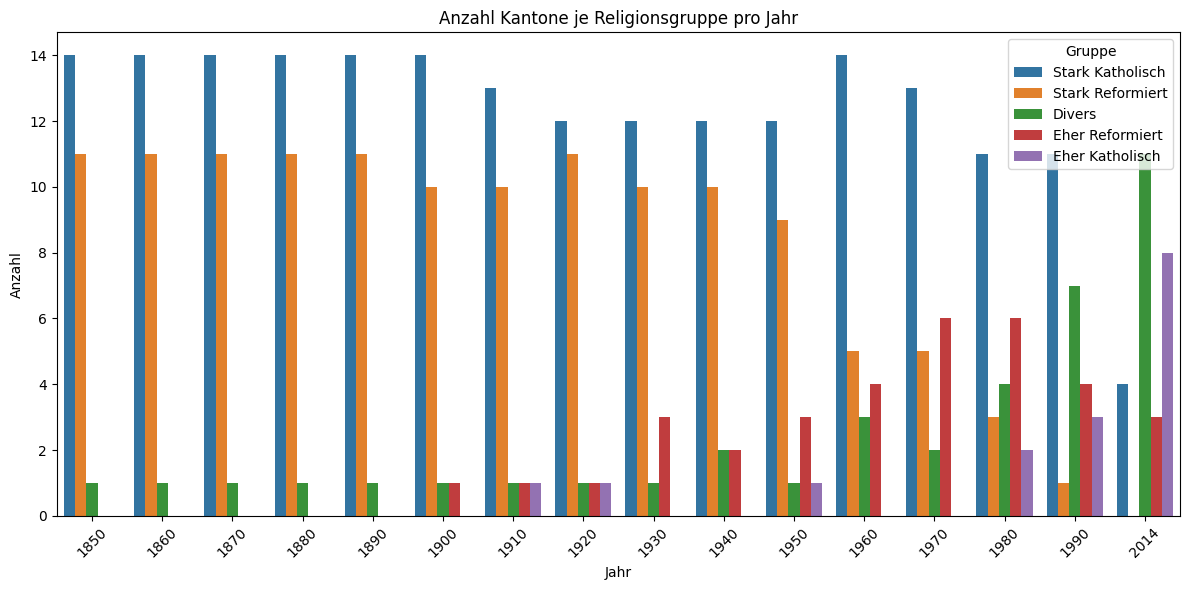

In [55]:


# DataFrame 'df_grouped' muss bereits existieren und folgendes enthalten:
# Spalten im Format "1850_Gruppe", "1860_Gruppe", ..., mit Werten wie 'Stark_Kat', 'Eher_Kat' etc.

# Schritt 1: Gruppenzählung vorbereiten
group_counts_per_year = pd.DataFrame()

for col in df_grouped.columns:
    year = col.replace("_Gruppe", "")
    counts = df_grouped[col].value_counts().rename_axis("Gruppe").reset_index(name="Anzahl")
    counts["Jahr"] = year
    group_counts_per_year = pd.concat([group_counts_per_year, counts], ignore_index=True)

# Schritt 2: Visualisierung
plt.figure(figsize=(12, 6))
sns.barplot(data=group_counts_per_year, x="Jahr", y="Anzahl", hue="Gruppe")
plt.title("Anzahl Kantone je Religionsgruppe pro Jahr")
plt.xticks(rotation=45)
plt.legend(title="Gruppe")
plt.tight_layout()
plt.show()


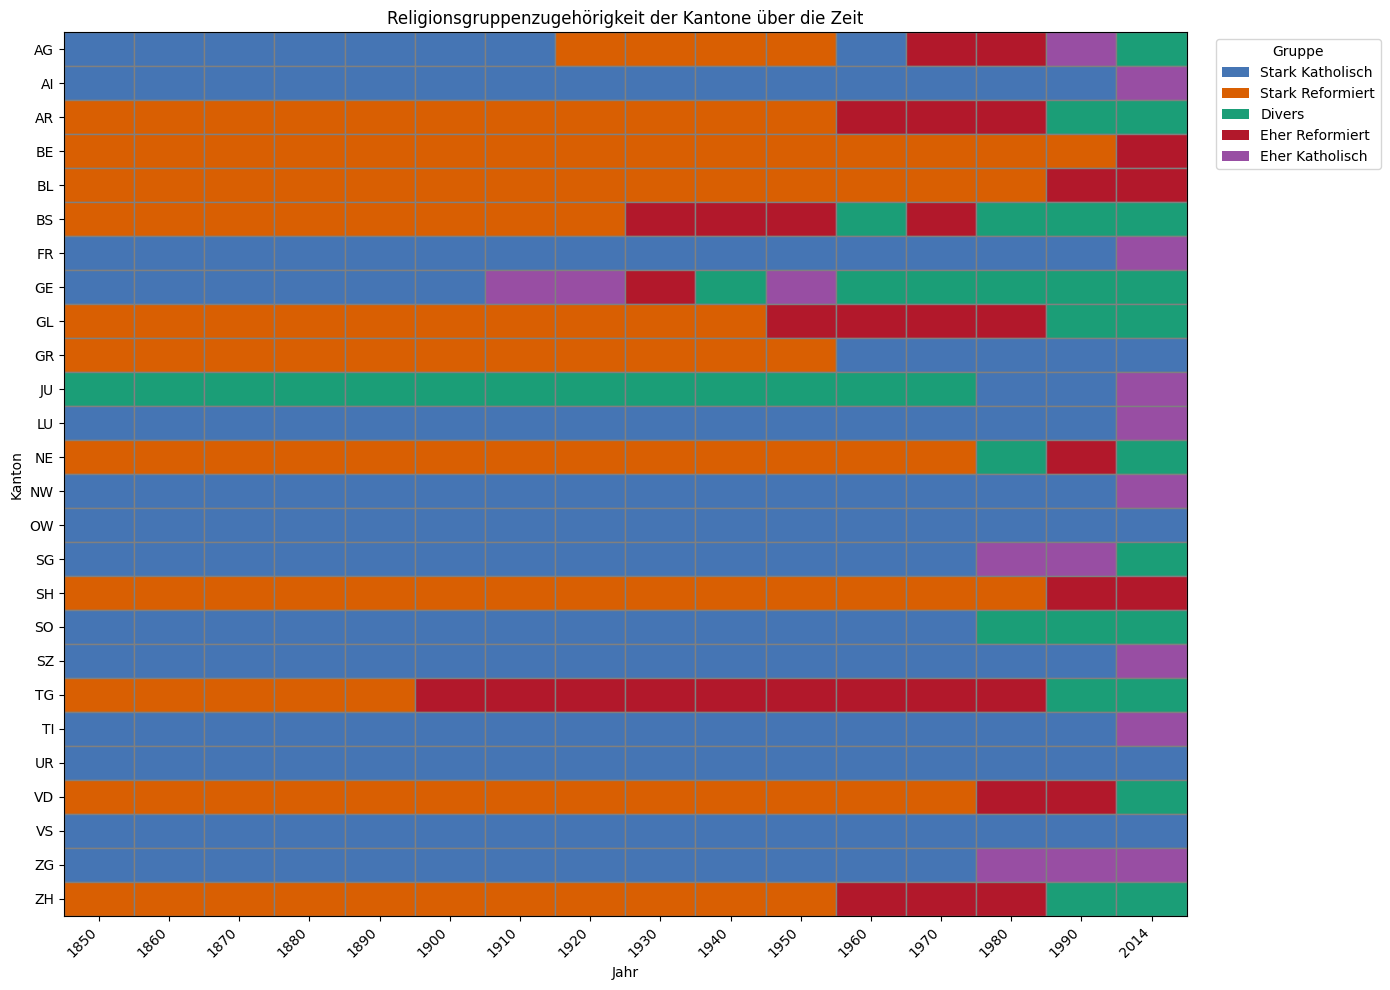

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1. DataFrame vorbereiten (df_grouped muss vorher schon vorhanden sein)
group_heatmap = pd.DataFrame(index=df_grouped.index)
for jahr in sorted(df_grouped.columns):
    if jahr.endswith("_Gruppe"):
        year = jahr.replace("_Gruppe", "")
        group_heatmap[year] = df_grouped[jahr]

# 2. Farbdefinition gemäss deiner Legende
custom_group_colors = {
    'Stark Katholisch': '#4575b4',   # Blau
    'Stark Reformiert': '#d95f02',   # Orange
    'Divers': '#1b9e77',       # Grün
    'Eher Reformiert': '#b2182b',    # Rot
    'Eher Katholisch': '#984ea3'     # Violett
}

# 3. Plot erstellen mit farbigen Rechtecken
fig, ax = plt.subplots(figsize=(14, 10))

kantone = group_heatmap.index.tolist()
jahre = group_heatmap.columns.tolist()

# Rechtecke für jede Zelle malen
for y_idx, kanton in enumerate(kantone):
    for x_idx, jahr in enumerate(jahre):
        gruppe = group_heatmap.loc[kanton, jahr]
        farbe = custom_group_colors.get(gruppe, "#ffffff")  # Weiß, wenn unbekannte Gruppe
        rect = plt.Rectangle((x_idx, y_idx), 1, 1, facecolor=farbe, edgecolor='gray')
        ax.add_patch(rect)

# 4. Achsen konfigurieren
ax.set_xlim(0, len(jahre))
ax.set_ylim(0, len(kantone))
ax.set_xticks([i + 0.5 for i in range(len(jahre))])
ax.set_xticklabels(jahre, rotation=45, ha="right")
ax.set_yticks([i + 0.5 for i in range(len(kantone))])
ax.set_yticklabels(kantone)
ax.invert_yaxis()
ax.set_title("Religionsgruppenzugehörigkeit der Kantone über die Zeit")
ax.set_xlabel("Jahr")
ax.set_ylabel("Kanton")

# 5. Legende manuell einfügen
legend_elements = [Patch(facecolor=color, label=label) for label, color in custom_group_colors.items()]
ax.legend(handles=legend_elements, title="Gruppe", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()

# 6. Optional speichern
plt.savefig("Religionsgruppen_Kanton_Jahr.png", dpi=300)
plt.show()
